# NACA 4 DIGIT AIRFOIL and CATIA FILE

## NACA 4 digit airfoil specification

This NACA airfoil series is controlled by 4 digits e.g. NACA 2412, which designate the camber, position of the maximum camber and thickness. If an airfoil number is

**NACA MPXX**

e.g.

**NACA 2412**


then:
* 	M is the maximum camber divided by 100. In the example M=2 so the camber is 0.02 or 2% of the chord
* 	P is the position of the maximum camber divided by 10. In the example P=4 so the maximum camber is at 0.4 or 40% of the chord.
* 	XX is the thickness divided by 100. In the example XX=12 so the thiickness is 0.12 or 12% of the chord.

    

## NACA 4 digit airfoil calculation

The NACA airfoil section is created from a camber line and a thickness distribution plotted perpendicular to the camber line.

The equation for the camber line is split into sections either side of the point of maximum camber position (P). In order to calculate the position of the final airfoil envelope later the gradient of the camber line is also required. The equations are:


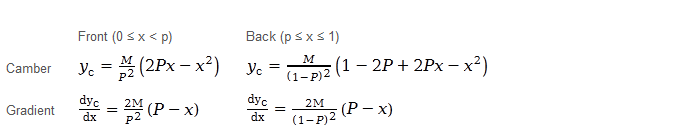

The thickness distribution is given by the equation:

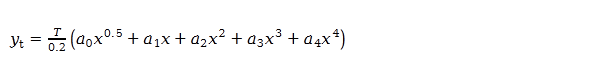

Where:

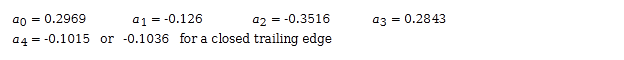

•	The constants a0 to a4 are for a 20% thick airfoil. The expression T/0.2 adjusts the constants to the required thickness.

•	At the trailing edge (x=1) there is a finite thickness of 0.0021 chord width for a 20% airfoil. If a closed trailing edge is required the value of a4 can be adjusted.

•	The value of yt is a half thickness and needs to be applied both sides of the camber line.
Using the equations above, for a given value of x it is possible to calculate the camber line position Yc, the gradient of the camber line and the thickness. The position of the upper and lower surface can then be calculated perpendicular to the camber line.


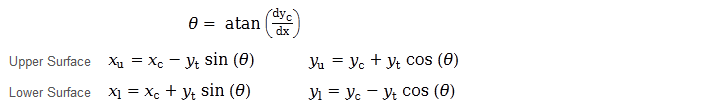

The most obvious way to to plot the airfoil is to iterate through equally spaced values of x calclating the upper and lower surface coordinates. While this works, the points are more widely spaced around the leading edge where the curvature is greatest and flat sections can be seen on the plots. To group the points at the ends of the airfoil sections a cosine spacing is used with uniform increments of β

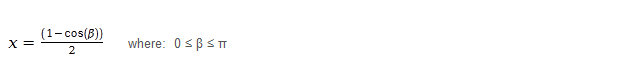

In [1]:
#pip install pycatia
# NOTE:: THIS CODE ASKS CATIA V5

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

from math import cos, sin
from math import atan
from math import pi
from math import pow
from math import sqrt


from pycatia import catia
from pycatia.scripts.csv_tools import create_points


default_FT = False
default_HalfCosine = False

def linspace(first,last,np):
    """
    Emulate Matlab linspace
    """
    return [first+(last-first)*i/(np-1) for i in range(np)]



def naca4(profile, n, finite_TE = default_FT, half_cosine_spacing = default_HalfCosine):

    # NACA MPTT
    
    M = float(profile[0])/100
    P = float(profile[1])/10
    TT = float(profile[2:])/100

    a0 = 0.2969
    a1 = -0.1260
    a2 = -0.3516
    a3 = 0.2843

    if finite_TE:
        a4 = -0.1015 # For finite thick TE
    else:
        a4 = -0.1036 # For zero thick TE

    if half_cosine_spacing:
        beta = linspace(0.0,pi,n+1)
        x = [((1-cos(bt))/2) for xx in beta]  # Half cosine based spacing
    else:
        x = linspace(0.0,1.0,n+1)

    yt = [(TT/0.2)*(a0*pow(bt,0.5)+a1*bt+a2*pow(bt,2)+a3*pow(bt,3)+a4*pow(bt,4)) for bt in x]

    xc1 = [bt for bt in x if bt <= P]
    xc2 = [bt for bt in x if bt > P]

    if P == 0:
        xu = x
        yu = yt

        xl = x
        yl = [-bt for bt in yt]

        xc = xc1 + xc2
        zc = [0]*len(xc)
    else:
        yc1 = [M/pow(P,2)*bt*(2*P-bt) for bt in xc1]
        yc2 = [M/pow(1-P,2)*(1-2*P+bt)*(1-bt) for bt in xc2]
        zc = yc1 + yc2

        dyc1_dx = [M/pow(P,2)*(2*P-2*bt) for bt in xc1]
        dyc2_dx = [M/pow(1-P,2)*(2*P-2*bt) for bt in xc2]
        dyc_dx = dyc1_dx + dyc2_dx

        teta = [atan(bt) for bt in dyc_dx]

        xu = [bt - yy * sin(zz) for bt,yy,zz in zip(x,yt,teta)]
        yu = [bt + yy * cos(zz) for bt,yy,zz in zip(zc,yt,teta)]

        xl = [bt + yy * sin(zz) for bt,yy,zz in zip(x,yt,teta)]
        yl = [bt - yy * cos(zz) for bt,yy,zz in zip(zc,yt,teta)]

    X = xu[::-1] + xl[1:]
    Z = yu[::-1] + yl[1:]
    
    d = {'X': X, 'Z': Z}
    df = pd.DataFrame(data=d)
    
    np.savetxt("NACA"+profile+".txt", df.values, fmt='%10.6f',header="    NACA "+profile,comments='')
    print("Zmax: ", round(max(Z), 6))
    axv=X[Z.index(max(Z))]
    print("X(Zmax): ", round(axv, 6))
    colors = (0,0,0)
    plt.figure(figsize=(18,4))
    
    plt.scatter(X, Z,alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.axvline(x=axv, color='r', linestyle='-')
    
    plt.title("NACA "+profile)
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.savefig("NACA"+profile+".png")
    plt.show()

    
    caa = catia()
    # create a new part and rename.
    documents = caa.documents
    documents.add('Part')
    document = caa.active_document

    part = caa.active_document.part()
    product = caa.active_document.product()
    hybrid_shape_factory = part.hybrid_shape_factory
    part_shape_factory = part.shape_factory
    body = part.main_body
    

    # create the hybrid bodies (Geometrical Set) to add our construction.
    hybrid_bodies = part.hybrid_bodies
    hybrid_body_points = hybrid_bodies.add()
    hybrid_body_splines = hybrid_bodies.add()
    hybrid_body_surface = hybrid_bodies.add()
    hybrid_body_points.name = "construction_points"
    hybrid_body_splines.name = "construction_splines"
    hybrid_body_surface.name = "construction_surfaces"
    
    spline = hybrid_shape_factory.add_new_spline()
    # create the hybrid shape 'points'
    for i in range(1,2*n+1):
        point_i = hybrid_shape_factory.add_new_point_coord(X[i]*70,Z[i]*70,0 ) #scale *70
        hybrid_body_points.append_hybrid_shape(point_i) # add the points to 'construction_points'
        spline.add_point(point_i) # create the spline  

    spline.add_point(hybrid_shape_factory.add_new_point_coord(X[1]*70,Z[1]*70,0 )) #to close spline
    hybrid_body_splines.append_hybrid_shape(spline)

    # create the extrusion
    # plane used to define direction
    plane = part.origin_elements.plane_xy
    # have to create a direction object for extrusion.
    direction = hybrid_shape_factory.add_new_direction(plane)
    extrusion = hybrid_shape_factory.add_new_extrude(spline, i_offset_debut=20, i_offset_fin=20, i_direction=direction)
    hybrid_body_surface.append_hybrid_shape(extrusion)

    #main_body = part.main_body
    #part.in_work_object = main_body
    #part_shape_factory.add_new_thick_surface(extrusion, 50, 50, 10)

    part.update()

    return(df)



NACA 4 digit profile code: 2412
Zmax:  0.079199
X(Zmax):  0.339105


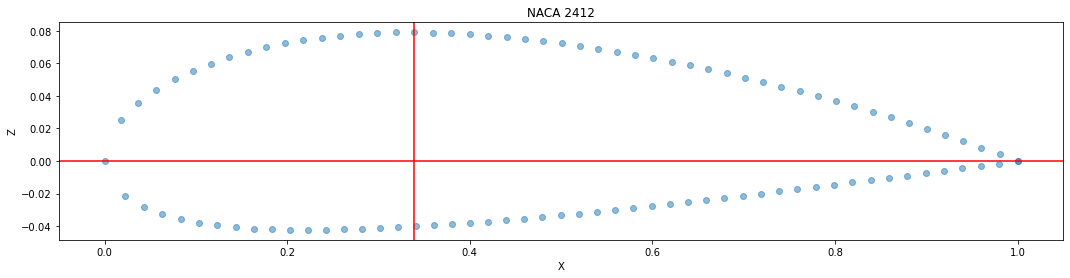

[2021-01-18 20:28:18,806] INFO in documents: Creating a new "Part".


,X,Z
0,1.000000,-1.661646e-17
1,0.980185,4.174916e-03
2,0.960352,8.233829e-03
3,0.940503,1.217948e-02
4,0.920638,1.601433e-02
...,...,...
96,0.919362,-6.058770e-03
97,0.939497,-4.579476e-03
98,0.959648,-3.078274e-03
99,0.979815,-1.552694e-03


In [2]:
profile = input("NACA 4 digit profile code: ")
naca4(profile, n=50, finite_TE = default_FT, half_cosine_spacing = default_HalfCosine)


---
---